# Finding a Mossy Glowshroom Sapling

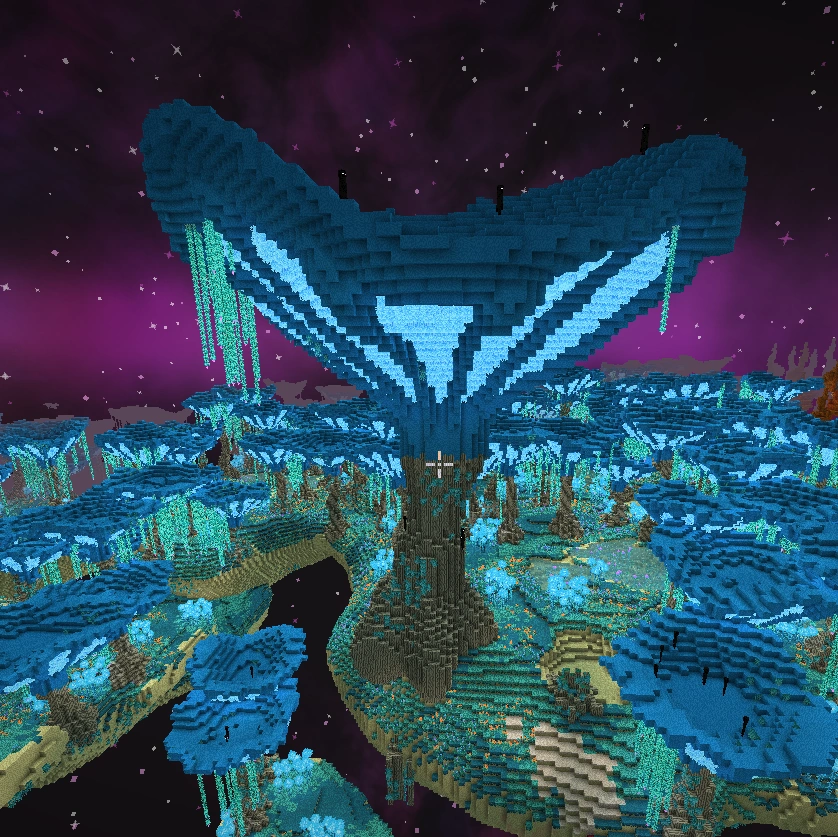

I'm playing Minecraft with the BetterEnd mod, and I would really love to get some of those _gorgeous_ giant mossy glowshrooms in the overworld. The only problem is that the saplings aren't farmable--[as far as I can tel](https://github.com/search?q=repo%3Aquiqueck%2FBetterEnd%20mossy_glowshroom_sapling&type=code) the only way to obtain them is by finding a chest in a [foggy mushroom biome](https://github.com/quiqueck/BetterEnd/blob/c273e6486fff5c53df9ff2e8699022e13e23da99/src/main/generated/data/betterend/loot_tables/chests/biome.json#L277). Well that should be something I can search for.

## Setup and Macros

In [1]:
import json
import math
from os import environ
from pathlib import Path
from typing import Any, Collection, Dict, List, Set

import mutf8
import pandas as pd
from IPython.display import Markdown, display
from nbt import nbt, region

In [2]:
def summarize_keystore(keystore: Dict[str, Any]) -> None:
    """Display a summary of the contents of a key-value store

    Parameters
    ----------
    keystore : dict
        The keystore to summarize

    Returns
    -------
    None
    """

    def _summarize_keystore(keystore: Dict[str, Any]) -> str:
        summary = ""
        for k, v in keystore.items():
            summary += f"\n - `{k}` : "
            if isinstance(v, (str, nbt.TAG_String)):
                summary += f'`"{v}"`'
            elif not isinstance(v, Collection):
                summary += f"`{str(v)}`"
            else:
                length = len(v)
                if 0 < length < 3:
                    summary += "\n"
                    if not isinstance(v, Dict):
                        v = {i: item for i, item in enumerate(v)}
                    summary += "\n".join(
                        (f"\t{line}" for line in _summarize_keystore(v).split("\n"))
                    )
                else:
                    summary += f"({len(v)} items)"
        return summary

    display(Markdown(_summarize_keystore(keystore)))

In [3]:
save_folder = Path(environ["SAVE_PATH"])
assert save_folder.exists()

## Chest Identification

In [4]:
end_region_files = sorted(
    (save_folder / "DIM1" / "region").glob("*"), key=lambda path: -path.stat().st_size
)
print(f"There are {len(end_region_files)} region files to search through.")

There are 127 region files to search through.


In [5]:
%%time
unique_loot_tables = []
for path in end_region_files:
    region_data = region.RegionFile(path)
    for chunk in region_data.iter_chunks():
        for entity in chunk["block_entities"]:
            if "chest" not in entity["id"].value:
                continue
            if "LootTable" not in entity:
                continue
            loot_table = entity["LootTable"].value
            if loot_table not in unique_loot_tables:
                print(f"Found a new loot table:\n - {loot_table}")
                unique_loot_tables.append(loot_table)

Found a new loot table:
 - betterend:chests/foggy_mushroomland
Found a new loot table:
 - betterend:chests/umbrella_jungle
Found a new loot table:
 - betterend:chests/biome
Found a new loot table:
 - betterend:chests/end_village_loot
Found a new loot table:
 - minecraft:chests/end_city_treasure
Found a new loot table:
 - betterend:chests/lantern_woods
Found a new loot table:
 - betterend:chests/end_village_bonus_loot
CPU times: user 1min 20s, sys: 1.16 s, total: 1min 22s
Wall time: 1min 22s


So the chests to check are:
- loot table is "betterend:chests/foggy_mushroomland"
- loot table is "betterend:chests/biome" _and_ biome is Foggy Mushroomland.

I wonder why there are both... I suspect backwards compatibility?

## Biome Identification

I don't think I've ever looked at where biome data is stored before... Let's see what's at the chunk level.

In [6]:
region_data = region.RegionFile(end_region_files[0])
chunk = next(region_data.iter_chunks())
summarize_keystore(chunk)


 - `xPos` : `-96`
 - `yPos` : `0`
 - `block_ticks` : (0 items)
 - `isLightOn` : `1`
 - `InhabitedTime` : `0`
 - `sections` : (16 items)
 - `zPos` : `-32`
 - `PostProcessing` : (16 items)
 - `Status` : `"minecraft:full"`
 - `DataVersion` : `3465`
 - `structures` : 
	
	 - `0` : `"References"`
	 - `1` : `"starts"`
 - `fluid_ticks` : (0 items)
 - `Heightmaps` : (4 items)
 - `block_entities` : (0 items)
 - `LastUpdate` : `94077671`

In [7]:
summarize_keystore(chunk["sections"][0])


 - `Y` : `0`
 - `biomes` : 
	
	 - `0` : `"palette"`
	 - `1` : `"data"`
 - `block_states` : 
	
	 - `0` : `"palette"`

In [8]:
print(chunk["sections"][0]["biomes"]["palette"])

[TAG_String: minecraft:small_end_islands, TAG_String: betterend:foggy_mushroomland]


In [9]:
print(chunk["sections"][0]["biomes"]["data"])

[3674993371882992384]


Huh. That's not our expected list of 256 64-bit values...

In [10]:
math.log(chunk["sections"][0]["biomes"]["data"][0]) / math.log(2)

61.672447355918756

It does appear to be a 64-bit int, though.

So how do we get from a 64-bit int to 4096 values for the biome of each block?

Well to start--even though biomes are vertical, I'm pretty sure that's just by section, so we only need to split it into _256_ values.

That's still too many, so I'm guessing that smallest biome resolution isn't actually 1x1. 

We can hopefully figure out what it is by leveraging the fact that there are only two biomes in this particular chunk. Thus, the correct splitting should yield a list of 1s and 0s.

In [11]:
def split_block_value(value: int, n_bits: int) -> List[int]:
    """Split a 64-bit int into a number of smaller-bit ints

    Parameters
    ----------
    value: 64-bit int
        The int to split
    n_bits : int
        The number of bits for each resulting int

    Returns
    -------
    list of split bits
    """
    small_ints: List[int] = []
    for _ in range(64 // n_bits):
        value, remainder = divmod(value, 2**n_bits)
        small_ints.append(remainder)
    return small_ints

In [12]:
split_block_value(chunk["sections"][0]["biomes"]["data"][0], 4)

[0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3]

Well it's not 4

In [13]:
split_block_value(chunk["sections"][0]["biomes"]["data"][0], 3)

[0, 0, 4, 1, 3, 0, 0, 0, 3, 6, 0, 0, 0, 6, 4, 1, 0, 0, 4, 1, 3]

Higher resolution is resulting in more variation.

In [14]:
split_block_value(chunk["sections"][0]["biomes"]["data"][0], 8)

[0, 51, 0, 51, 0, 51, 0, 51]

Yeah, but that's not working either.

I think the only solution is where each is *binary* (1-bit), but certainly if a chunk can have multiple biomes, it can have more than _two_...

### I'm just going to ignore it

Instead, I can just check if "foggy mushroom" is _in_ the palette and declare the chest a _possible_ foggy chest.

## Let the Search Commence

In [15]:
%%time
foggy_chests: List = []
for path in end_region_files:
    region_data = region.RegionFile(path)
    for chunk in region_data.iter_chunks():
        for entity in chunk["block_entities"]:
            if "chest" not in entity["id"].value:
                continue
            if "LootTable" not in entity:
                continue
            loot_table = entity["LootTable"].value
            if loot_table == "betterend:chests/foggy_mushroomland":
                print(
                    f'Found Foggy Chest at {entity["x"].value, entity["y"].value, entity["z"].value}'
                )
            if loot_table == "betterend:chests/biome":
                section = chunk["sections"][entity["y"].value // 16]
                if "betterend:foggy_mushroomland" in (
                    biome.value for biome in section["biomes"]["palette"]
                ):
                    print(
                        f'Found Possible Foggy Chest at {entity["x"].value, entity["y"].value, entity["z"].value}'
                    )

Found Foggy Chest at (1219, 91, 1094)
Found Foggy Chest at (3414, 98, -195)
Found Foggy Chest at (234, 89, -1523)
Found Foggy Chest at (-963, 89, -1290)
Found Foggy Chest at (3725, 93, 1830)
Found Foggy Chest at (1702, 95, 1763)
Found Foggy Chest at (3306, 89, 1987)
Found Foggy Chest at (-874, 106, 1533)
CPU times: user 1min 21s, sys: 1.04 s, total: 1min 22s
Wall time: 1min 22s


That should be enough to get me started.